In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import albumentations as A
import torch
import torchvision
import torchvision.transforms as T
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import resnet50
import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Define paths
image_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/val/images'
detection_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/val/detections'
mask_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/val/masks'
model_1_dir = '/content/drive/My Drive/fasterrcnn_model.pth'
model_2_dir = '/content/drive/My Drive/maskrcnn_model.pth'

In [4]:
class LungTumorDataset(Dataset):
    def __init__(self, image_dir, detection_dir, mask_dir, transforms=None):
        self.image_paths = []
        self.label_paths = []
        self.mask_paths = []
        self.transforms = transforms

        subject_dirs = sorted(os.listdir(image_dir))
        for subject in subject_dirs:
            subject_img_dir = os.path.join(image_dir, subject)
            subject_lbl_dir = os.path.join(detection_dir, subject)
            subject_mask_dir = os.path.join(mask_dir, subject)

            for img_name in sorted(os.listdir(subject_img_dir)):
                img_path = os.path.join(subject_img_dir, img_name)
                label_name = os.path.splitext(img_name)[0] + ".txt"
                label_path = os.path.join(subject_lbl_dir, label_name)
                mask_path = os.path.join(subject_mask_dir, img_name)

                self.image_paths.append(img_path)
                self.label_paths.append(label_path)
                self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        mask_path = self.mask_paths[idx]

        img = np.array(Image.open(img_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    x_min, y_min, x_max, y_max = map(float, parts)
                    boxes.append([x_min, y_min, x_max, y_max])

        # Apply Albumentations transform using keyword arguments
        if self.transforms:
            transformed = self.transforms(image=img, bboxes=boxes, masks=[mask])
            img = transformed['image']
            boxes = transformed['bboxes']
            mask = transformed['masks'][0]
        if img.dtype == torch.uint8:
            img = img.float() / 255.0

        if not isinstance(boxes, torch.Tensor):
            boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64) if len(boxes) > 0 else torch.zeros((0,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return img, target, mask

In [5]:
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), size=(256, 256), p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

def collate_fn(batch):
    return tuple(zip(*batch))

<ipython-input-5-3a3c4a9a74c0>:4: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), size=(256, 256), p=0.5),


In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load dataset
dataset = LungTumorDataset(image_dir, detection_dir, mask_dir, transforms=albumentations_transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

Using device: cuda


In [8]:
models = []
model_1 = torch.load(model_1_dir, weights_only=False)
models.append(model_1)
model_2 = torch.load(model_2_dir, weights_only=False)
models.append(model_2)

Processing Sample 1
Processing Model 1


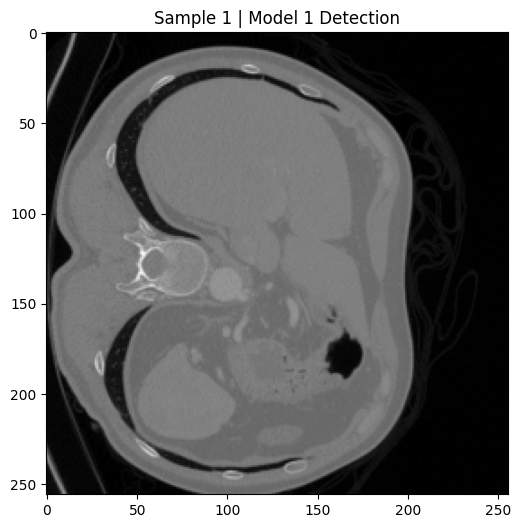

Processing Model 2


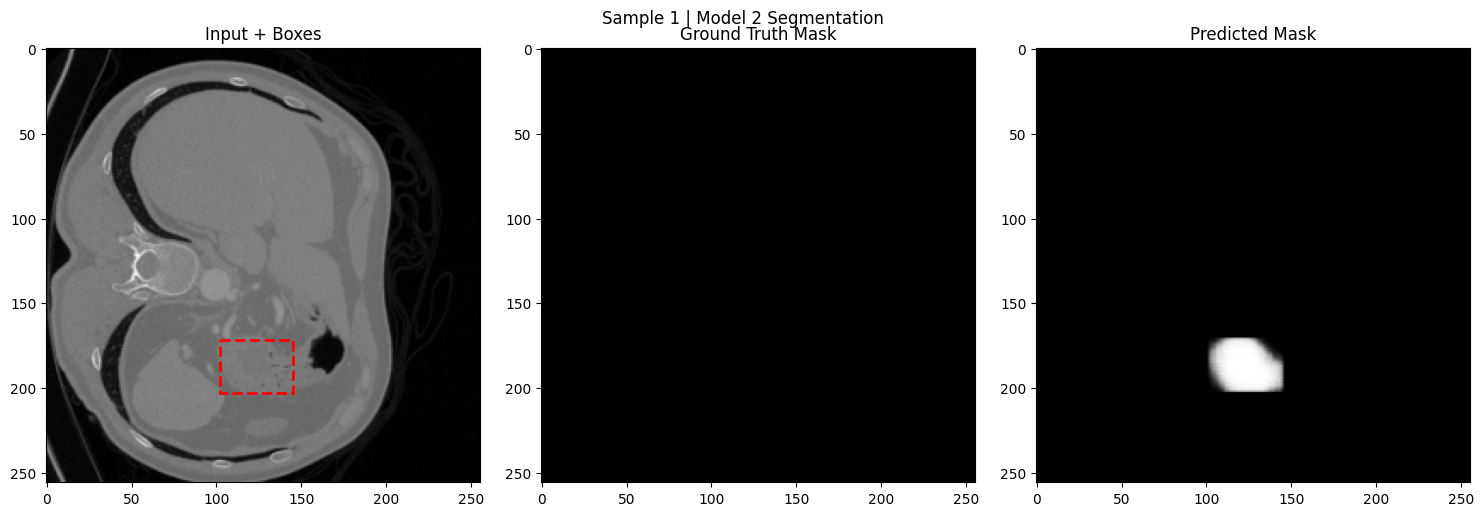

Processing Sample 2
Processing Model 1


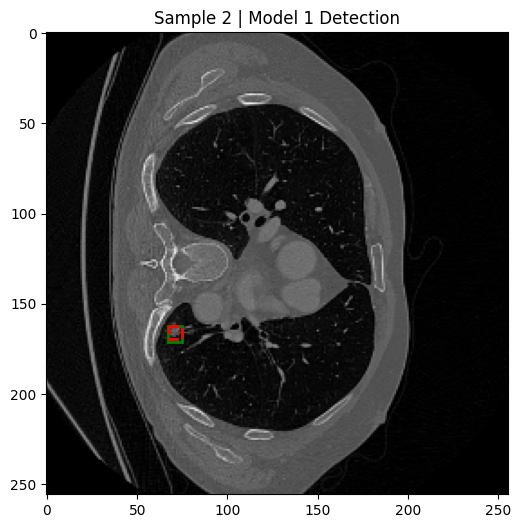

Processing Model 2


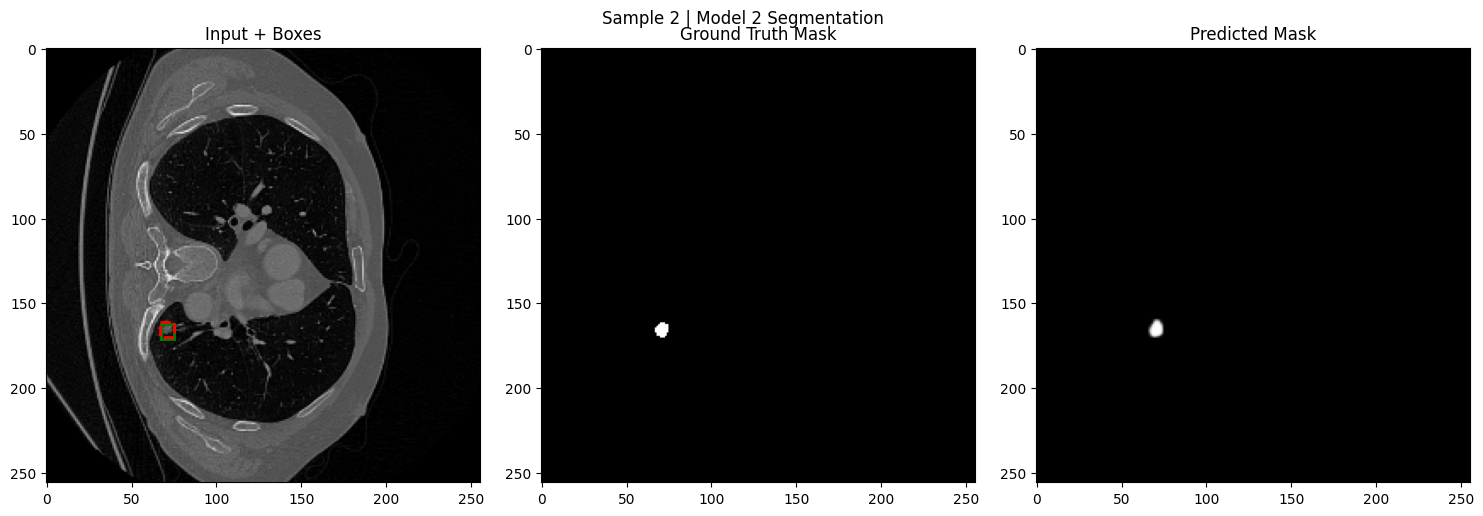

Processing Sample 3
Processing Model 1


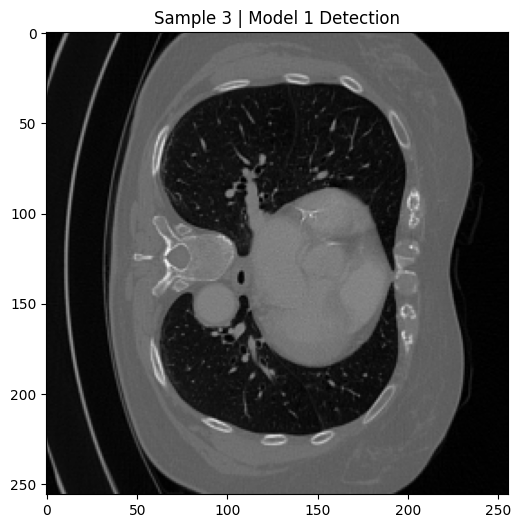

Processing Model 2


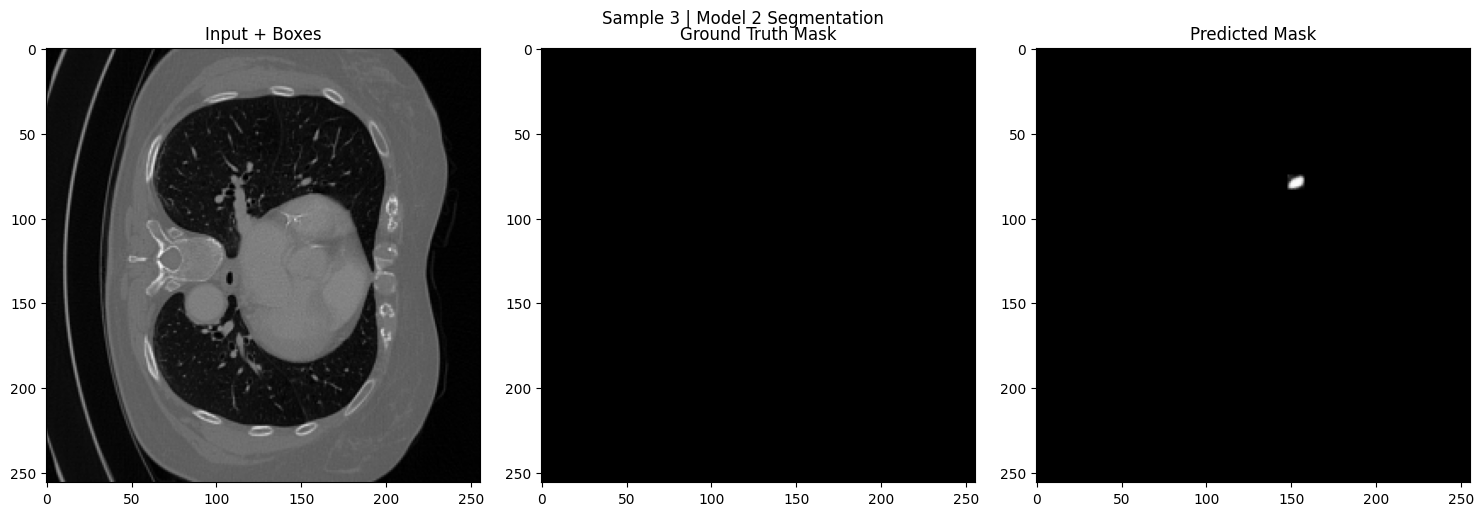

Processing Sample 4
Processing Model 1


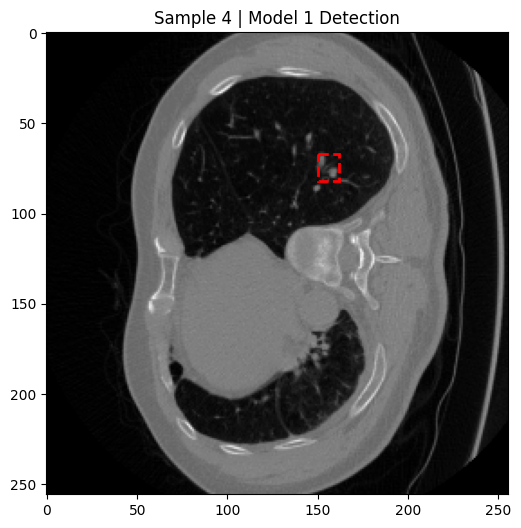

Processing Model 2


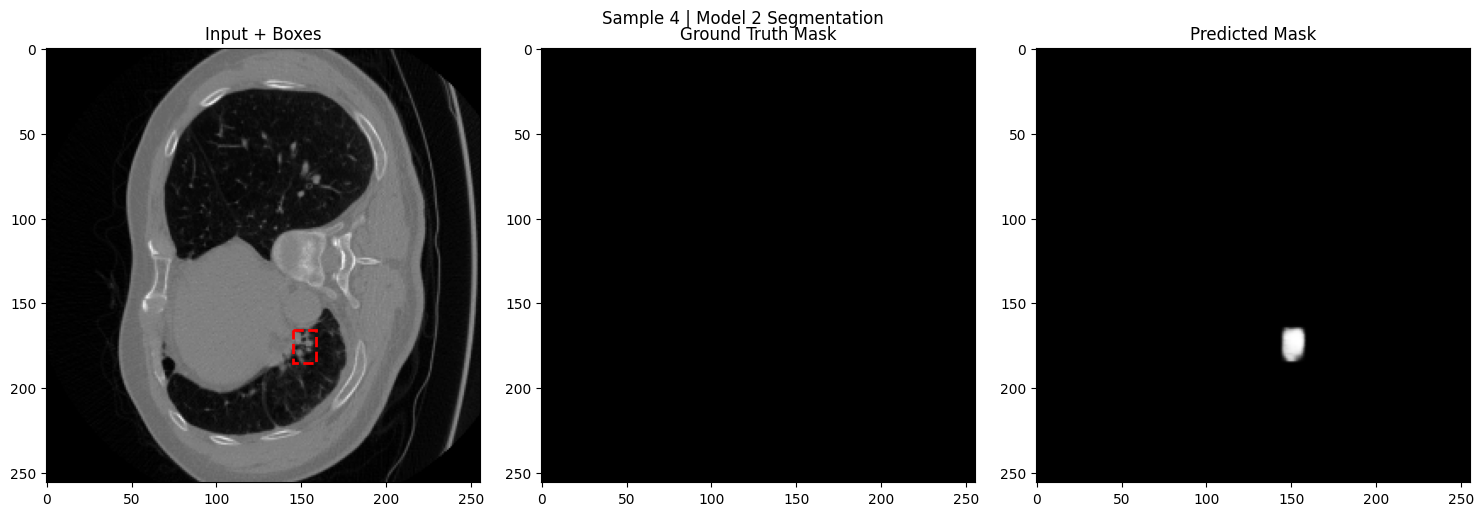

Processing Sample 5
Processing Model 1


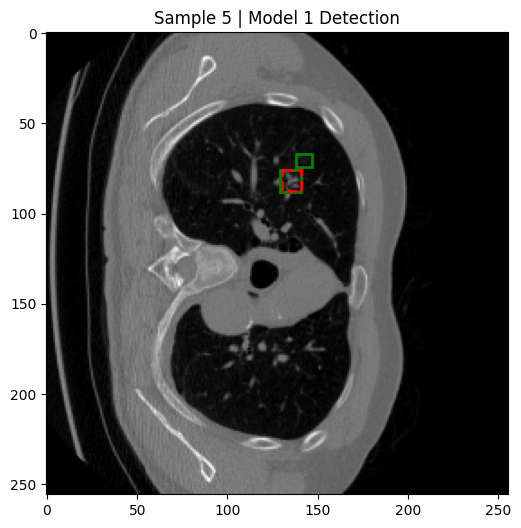

Processing Model 2


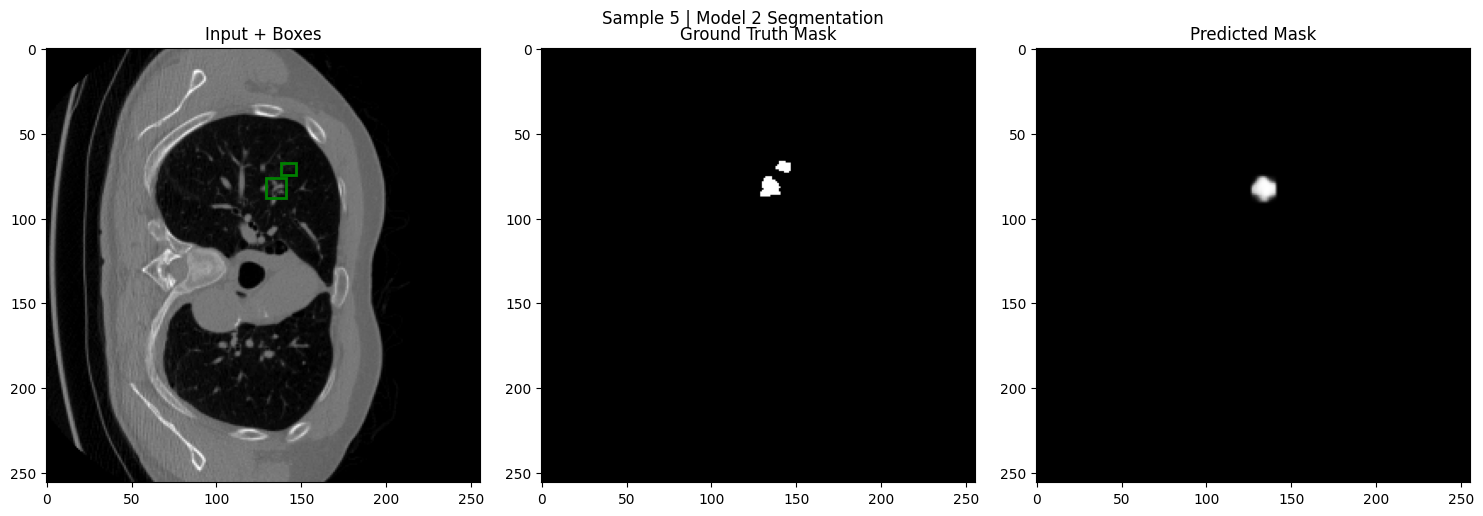

Processing Sample 6
Processing Model 1


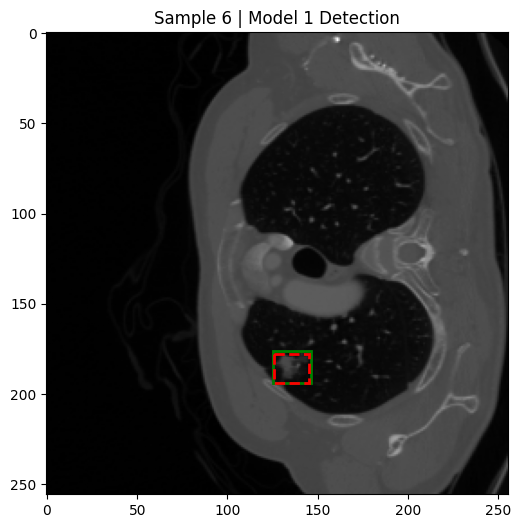

Processing Model 2


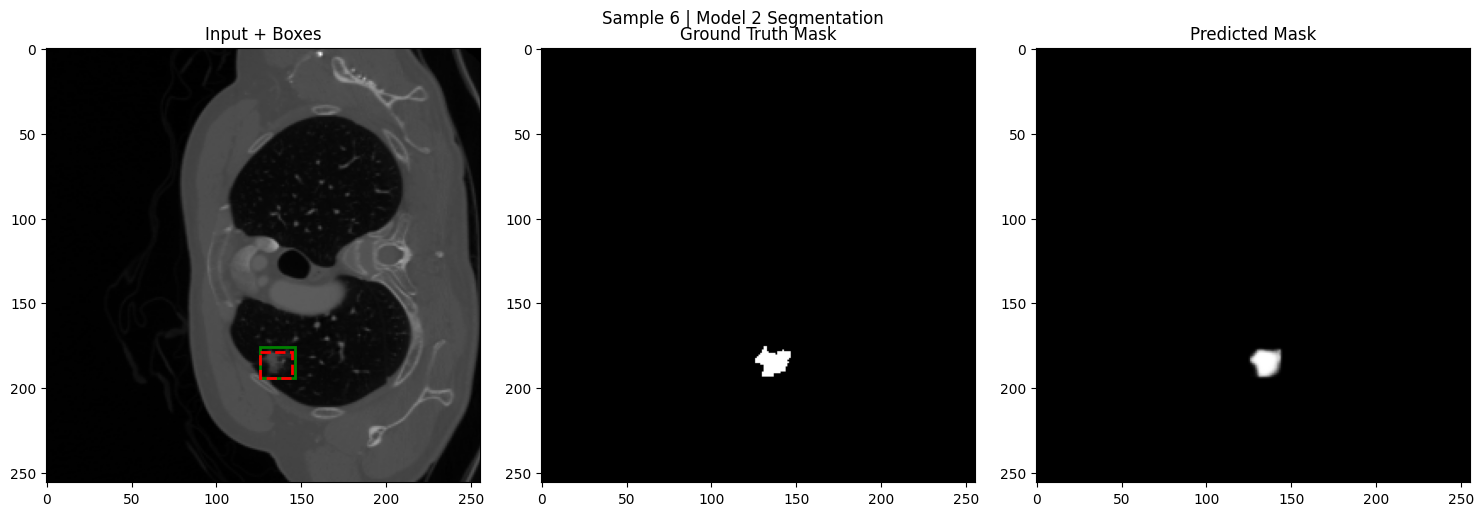

Processing Sample 7
Processing Model 1


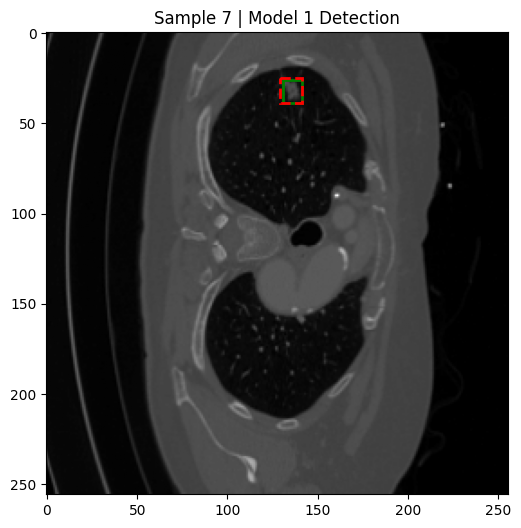

Processing Model 2


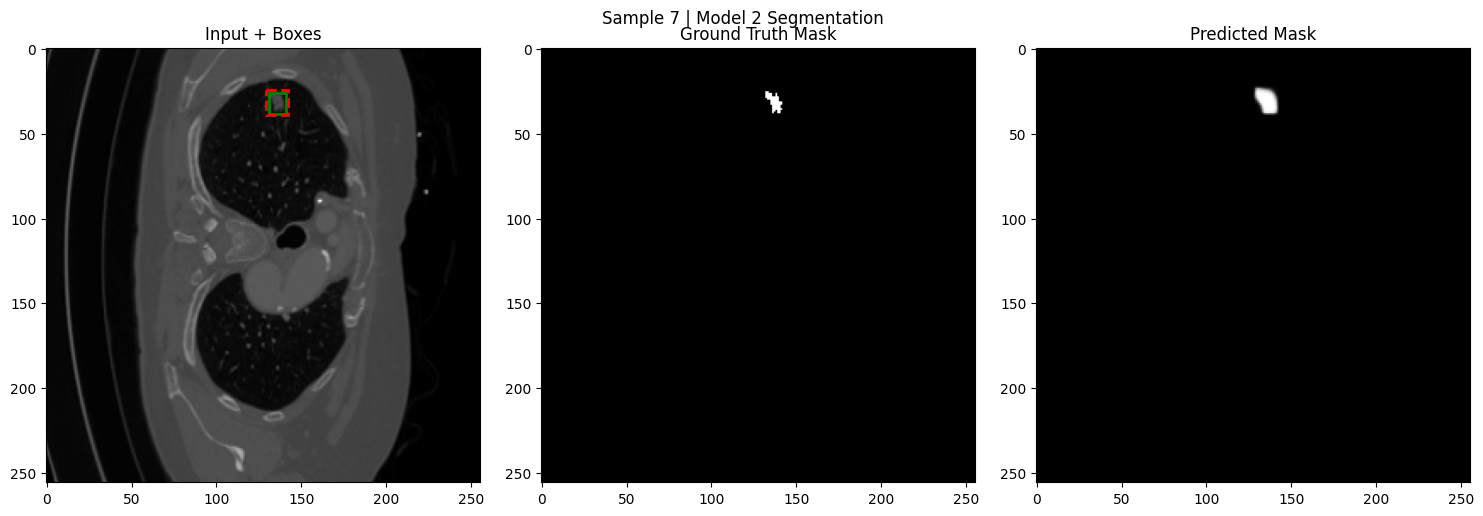

Processing Sample 8
Processing Model 1


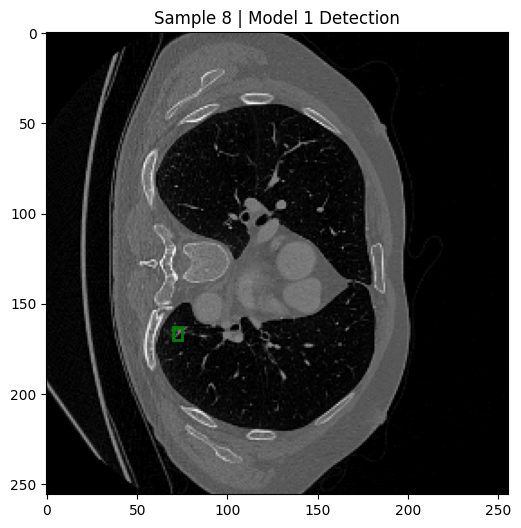

Processing Model 2


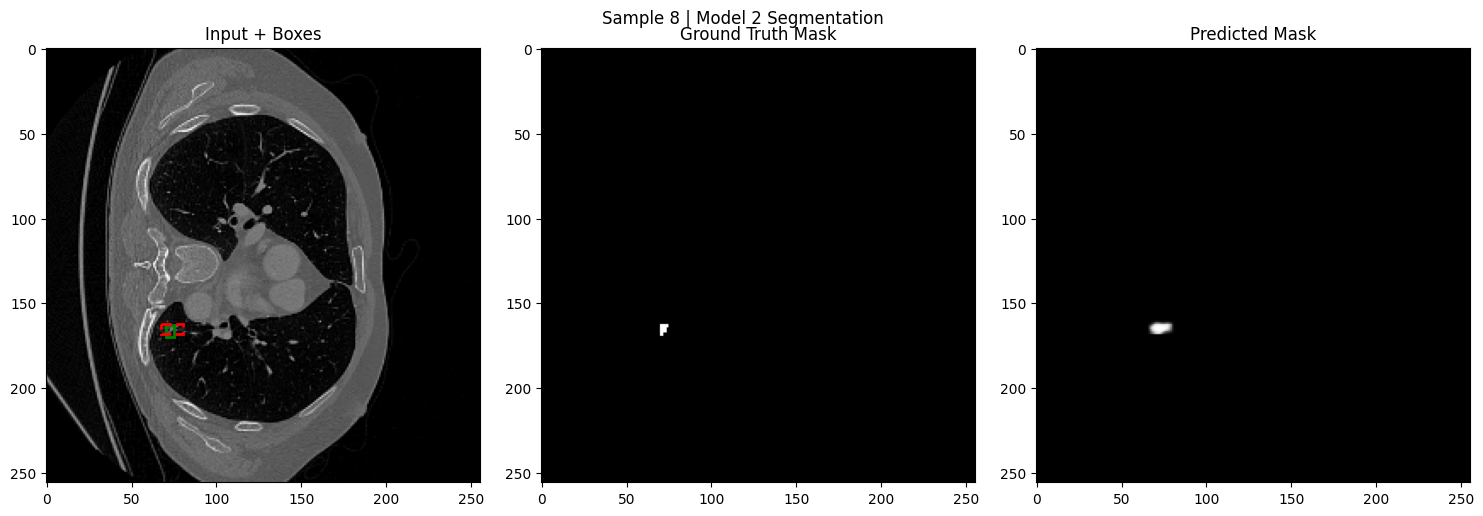

Processing Sample 9
Processing Model 1


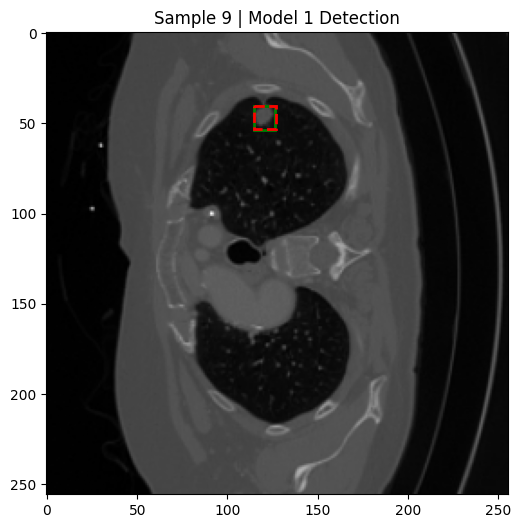

Processing Model 2


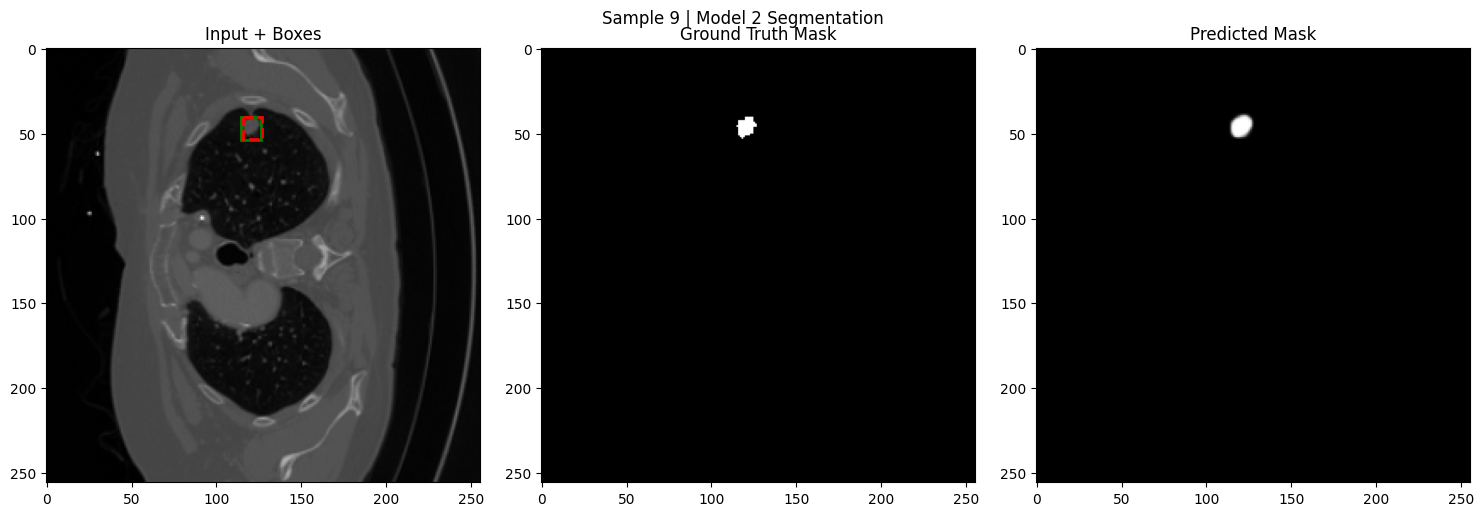

Processing Sample 10
Processing Model 1


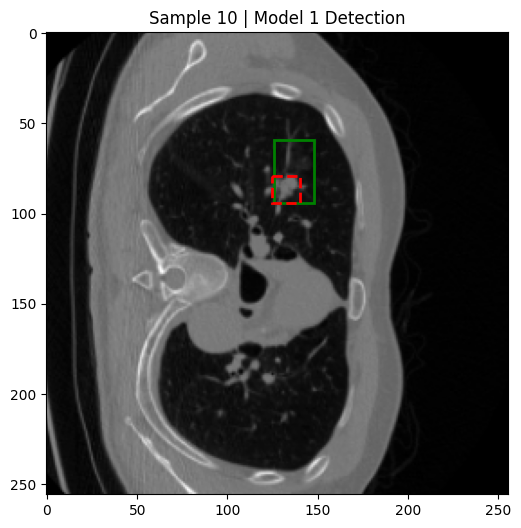

Processing Model 2


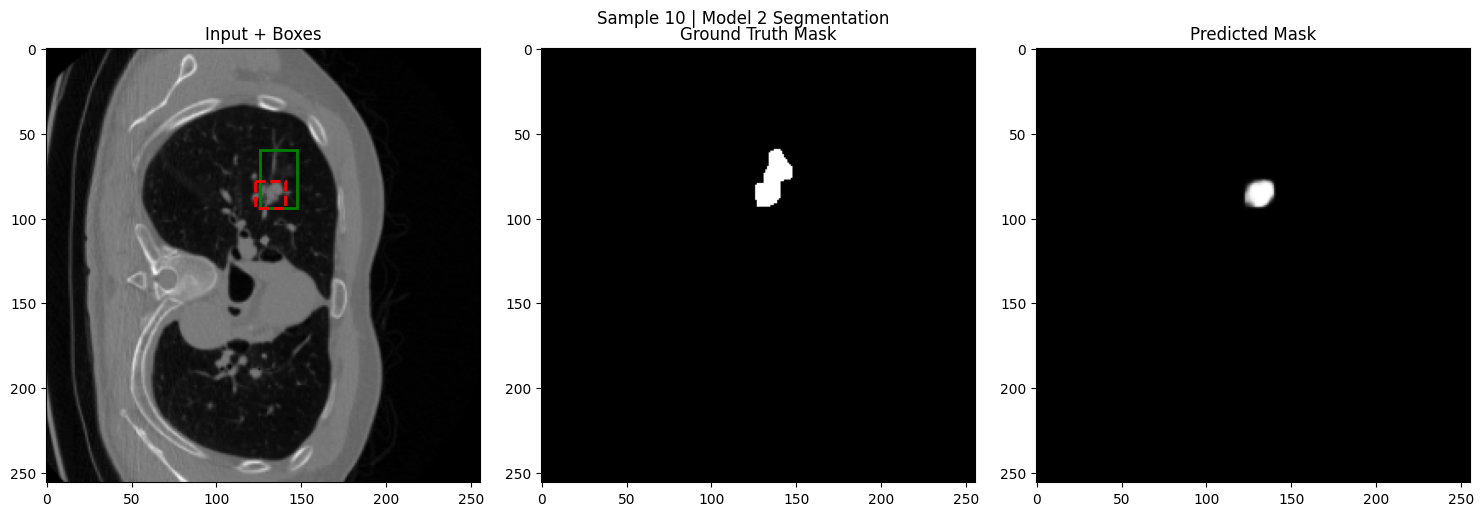

Processing Sample 11
Processing Model 1


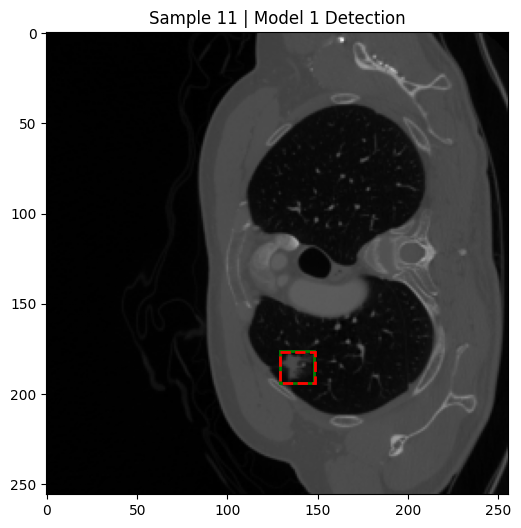

Processing Model 2


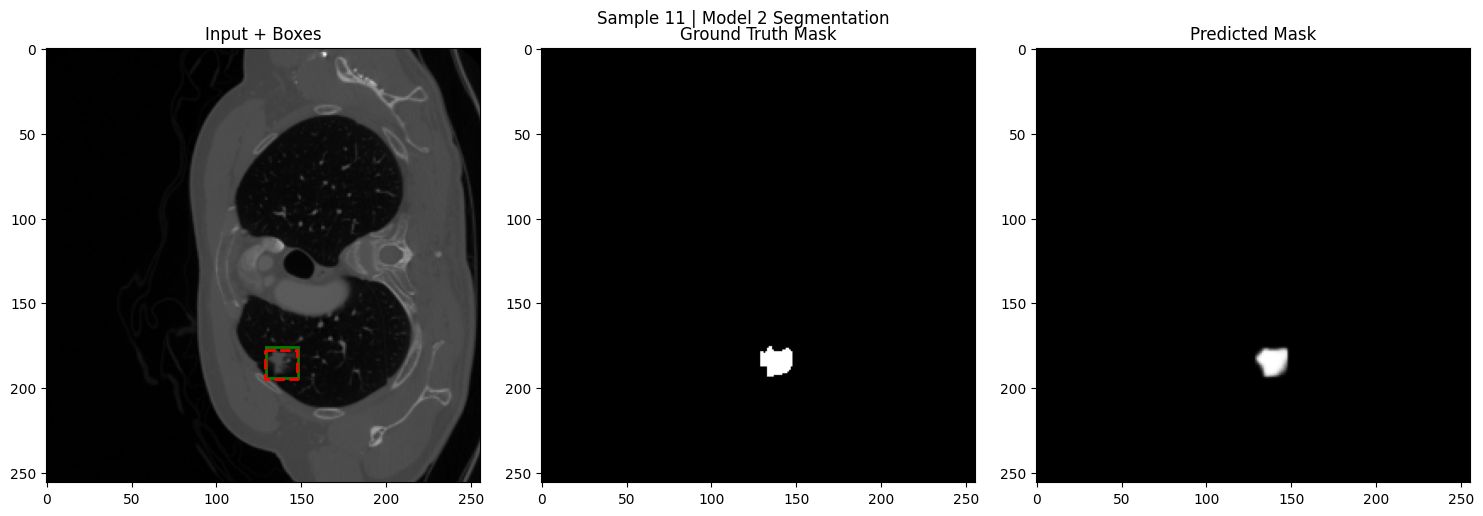

Processing Sample 12
Processing Model 1


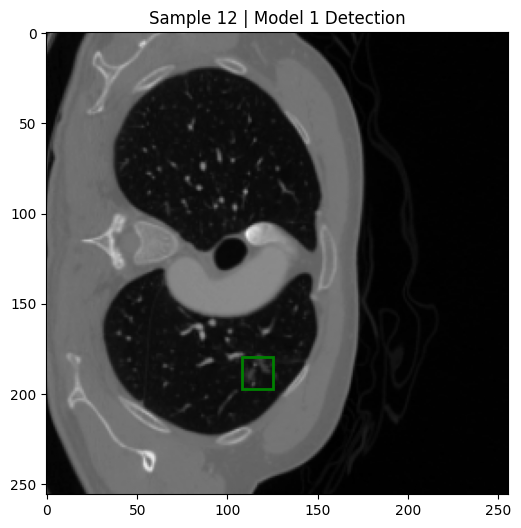

Processing Model 2


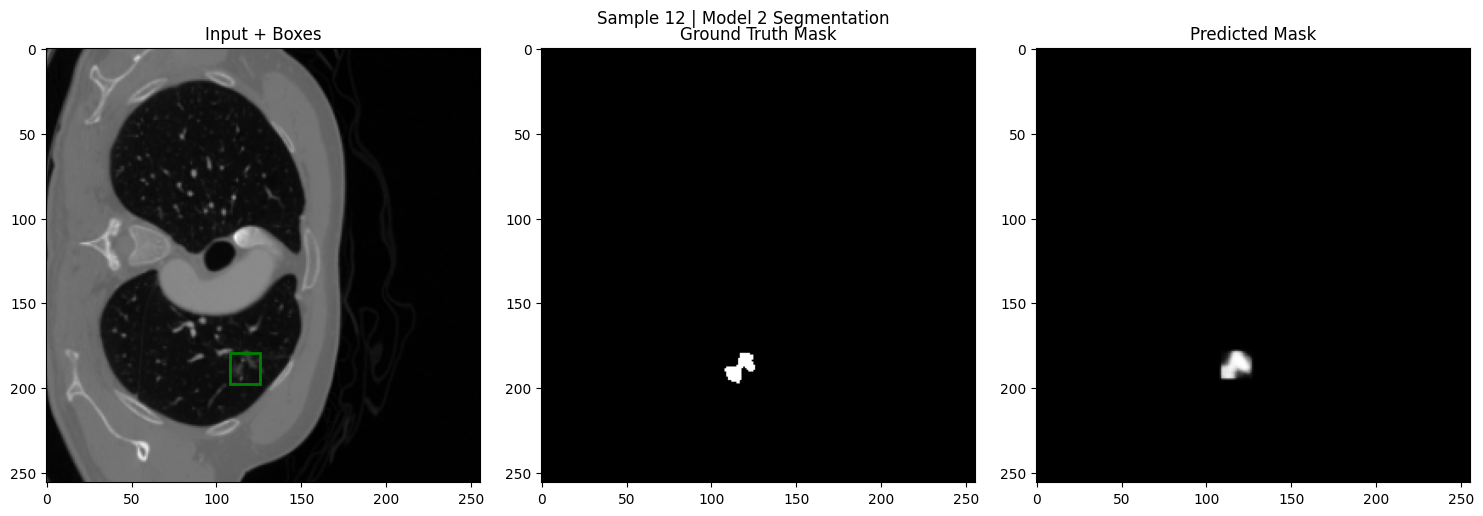

Processing Sample 13
Processing Model 1


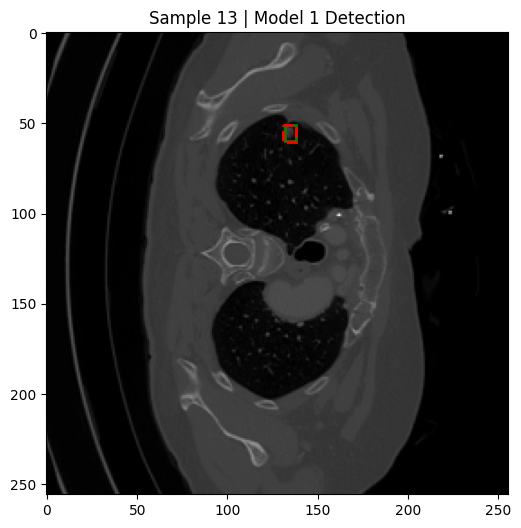

Processing Model 2


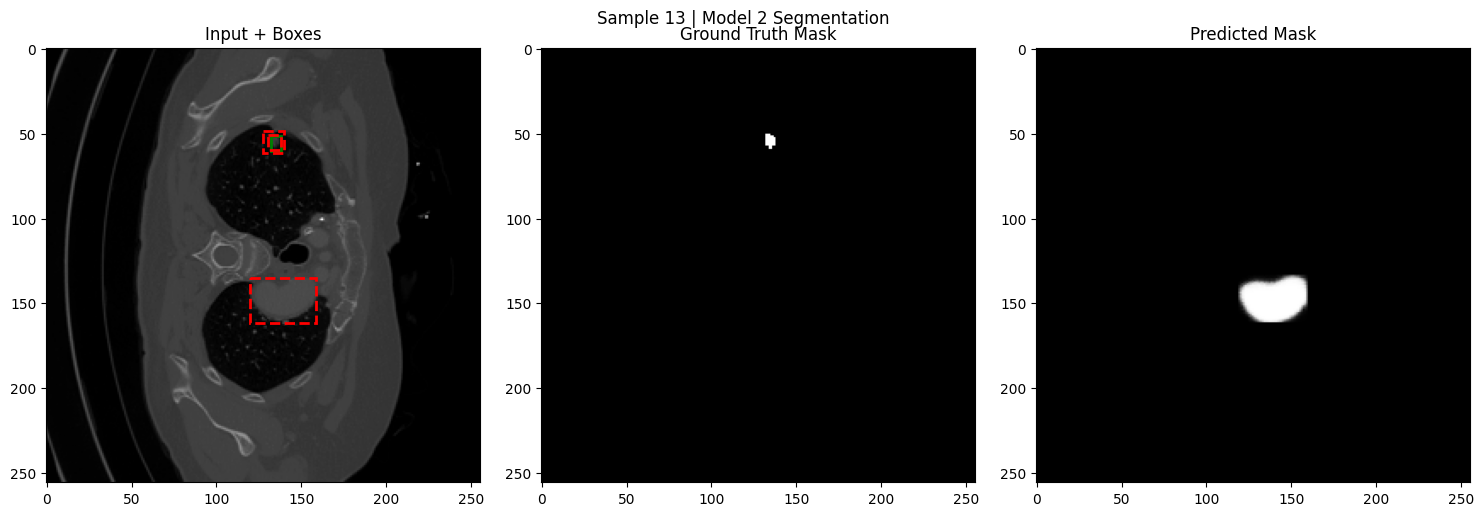

Processing Sample 14
Processing Model 1


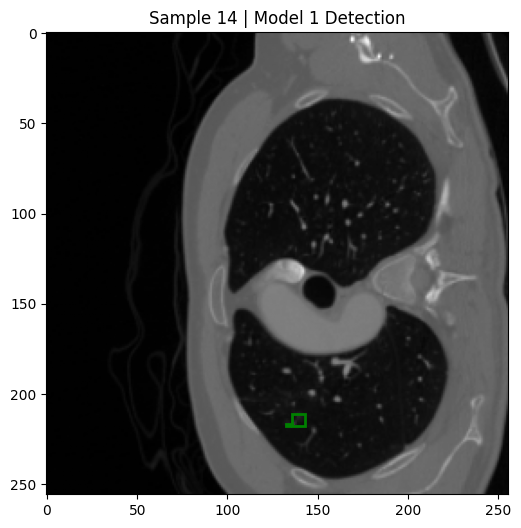

Processing Model 2


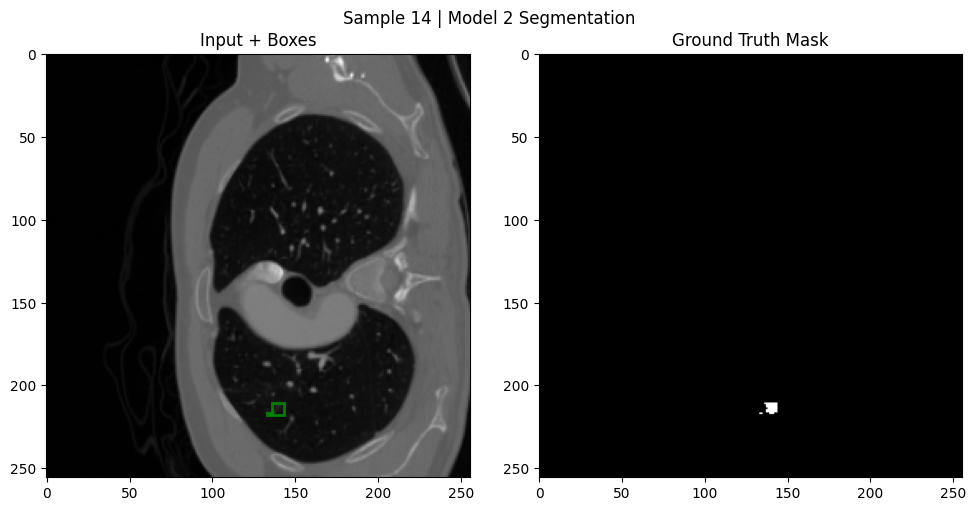

Processing Sample 15
Processing Model 1


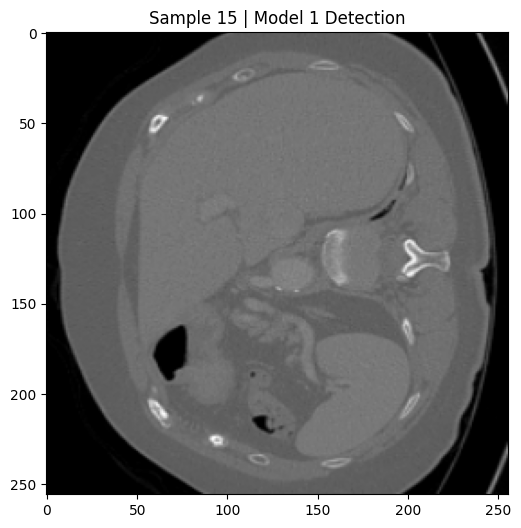

Processing Model 2


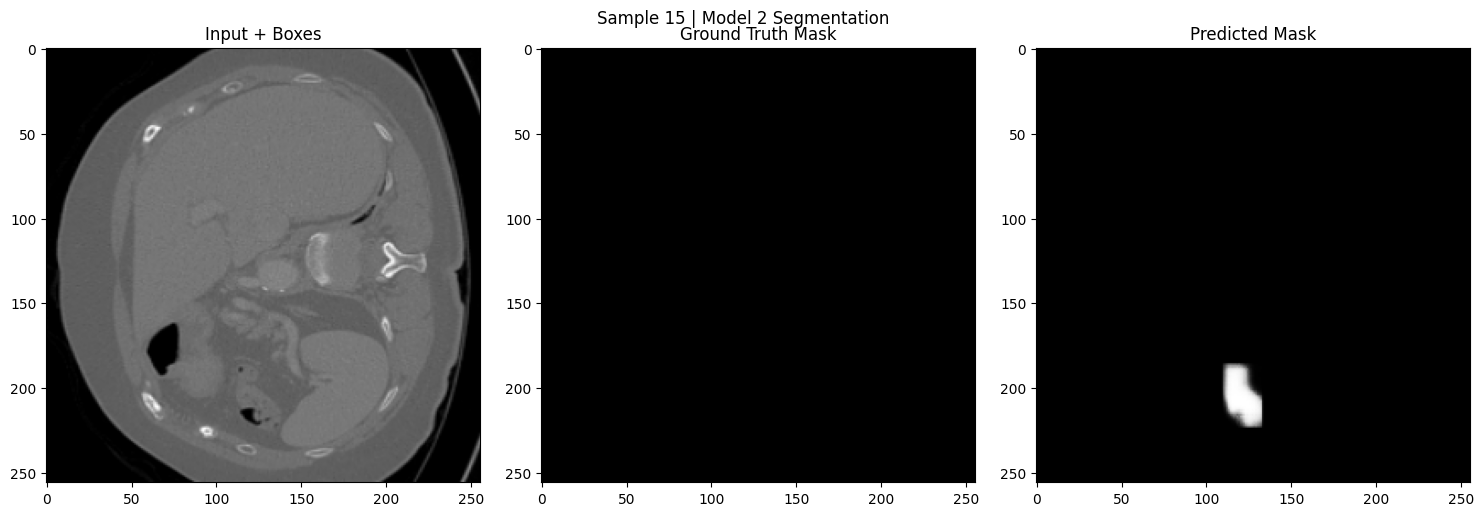

Processing Sample 16
Processing Model 1


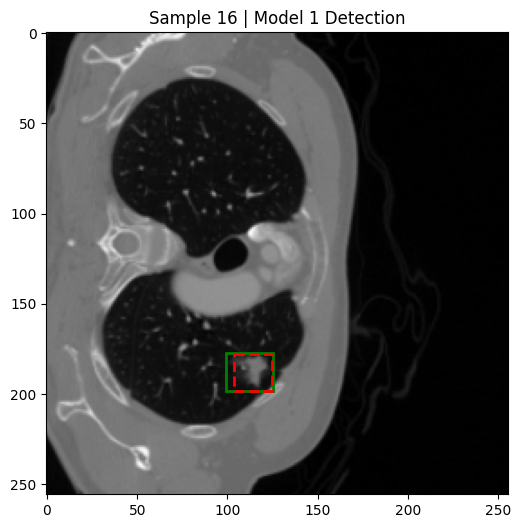

Processing Model 2


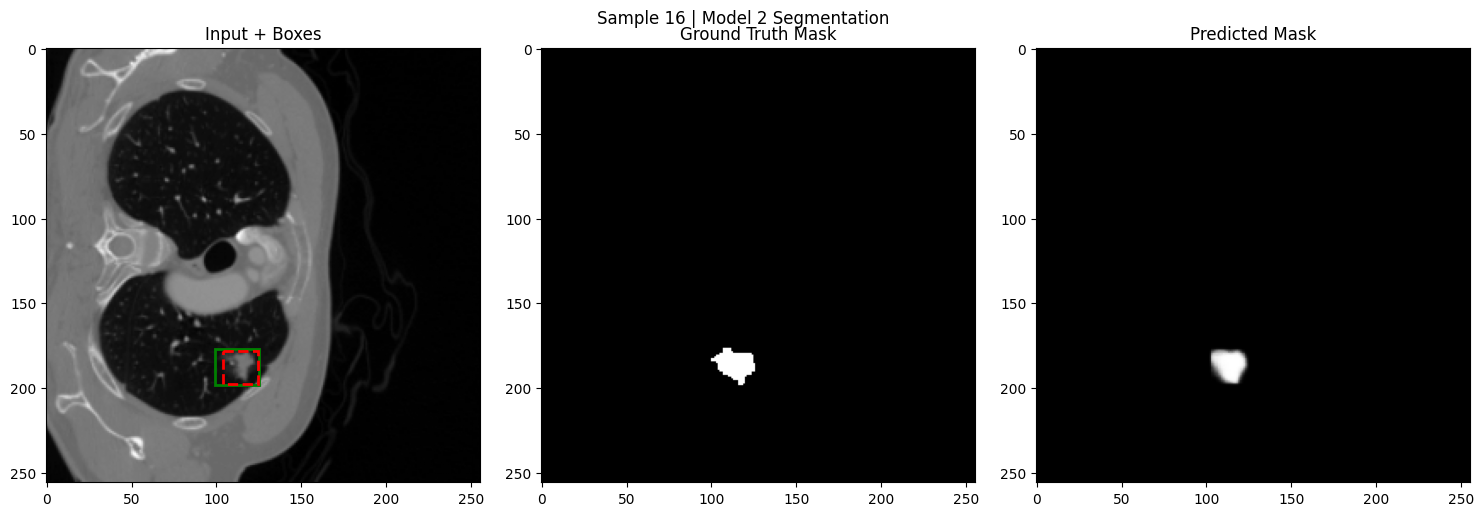

Processing Sample 17
Processing Model 1


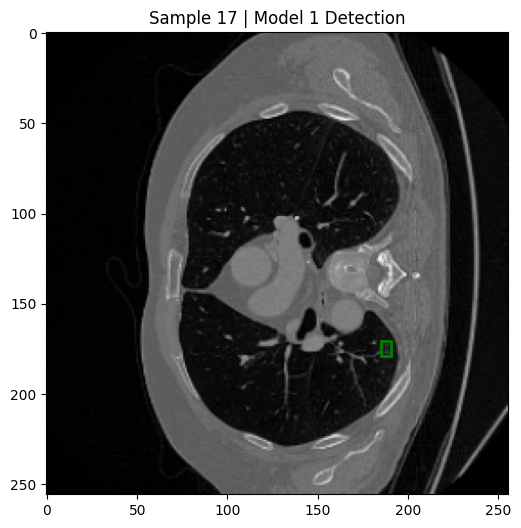

Processing Model 2


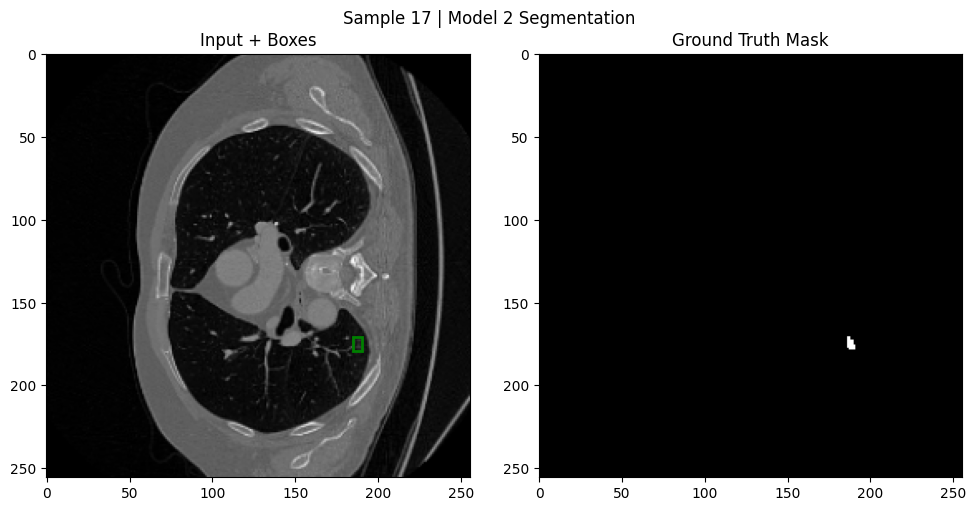

Processing Sample 18
Processing Model 1


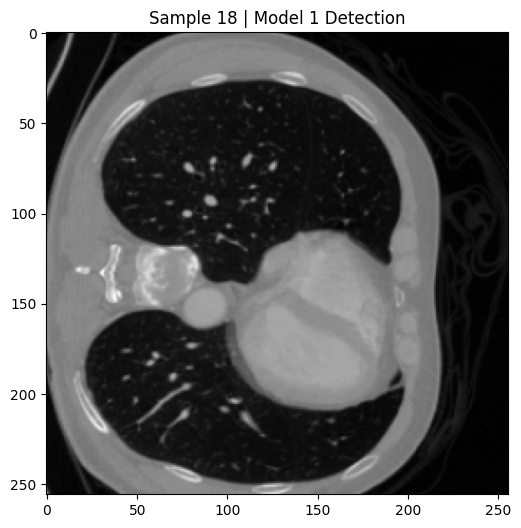

Processing Model 2


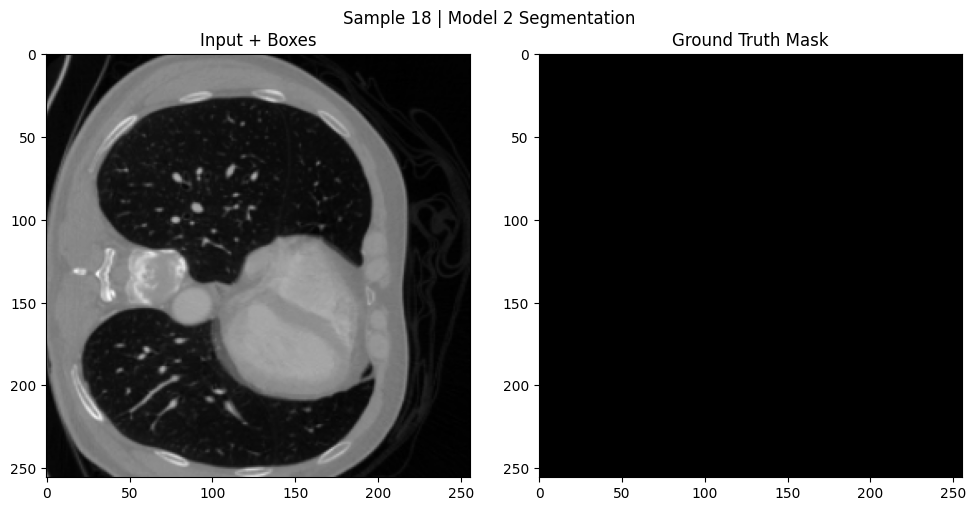

Processing Sample 19
Processing Model 1


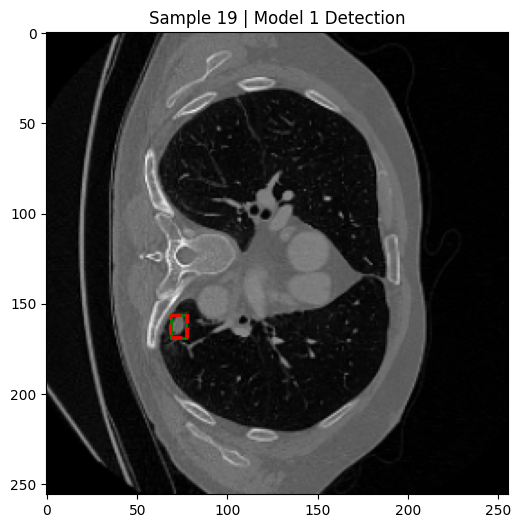

Processing Model 2


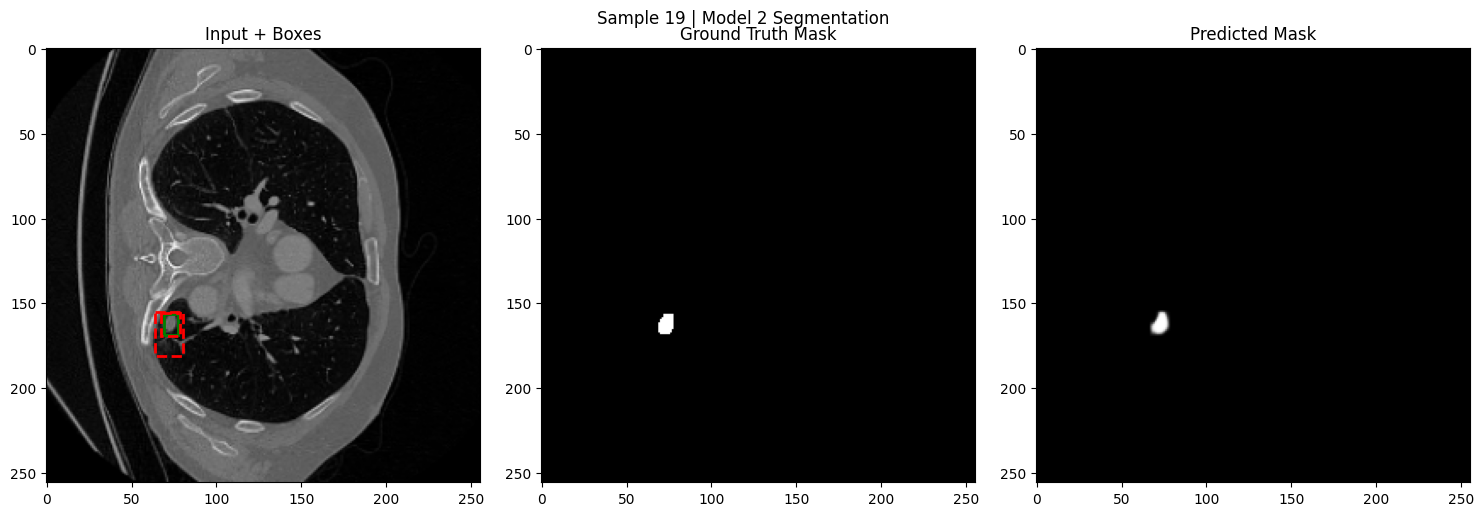

Processing Sample 20
Processing Model 1


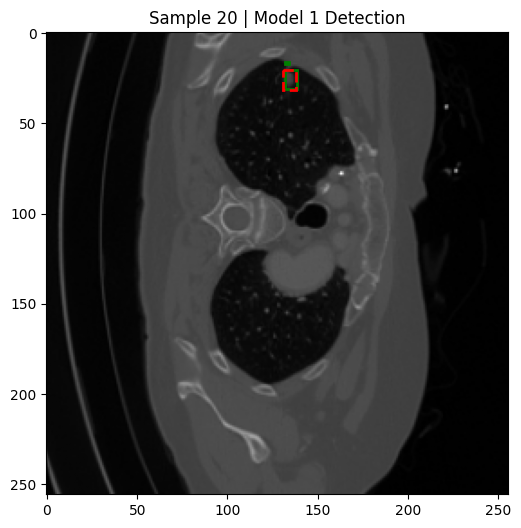

Processing Model 2


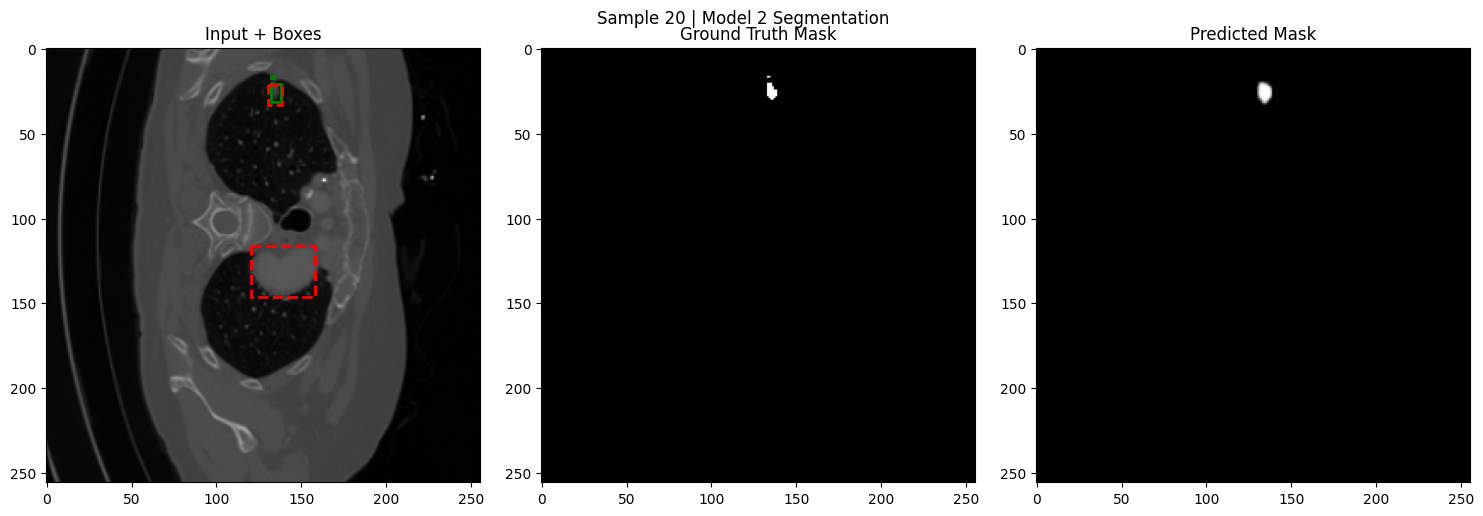

Processing Sample 21
Processing Model 1


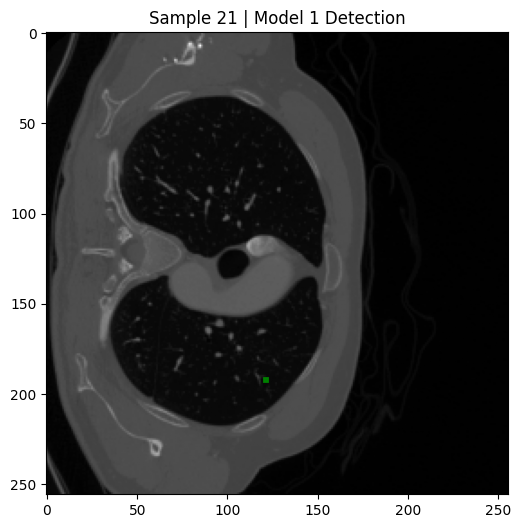

Processing Model 2


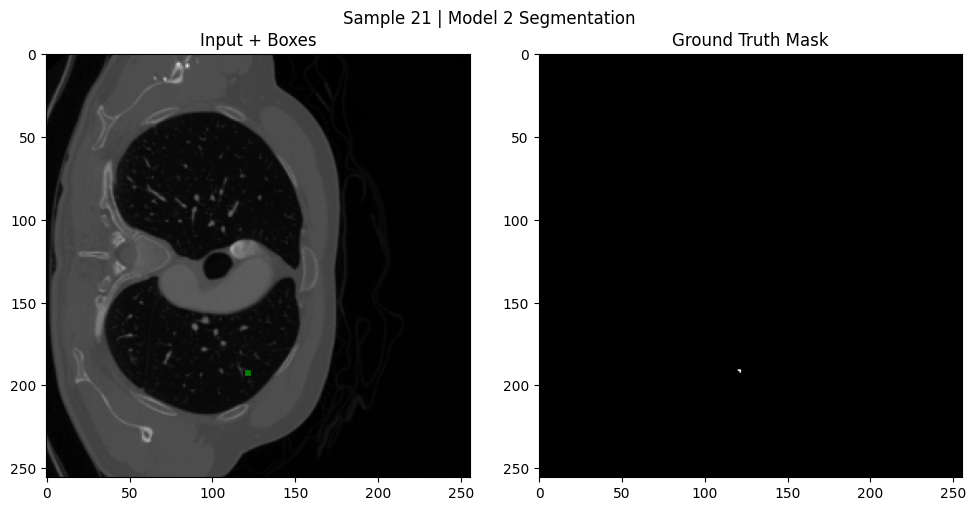

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.patches import Rectangle

def show_detection(image, target, pred_boxes=None, pred_scores=None,
                   title="", score_threshold=0.5):
    img_np = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_np, cmap='gray')
    ax.set_title(title)

    # Plot ground truth boxes (green)
    for box in target.get('boxes', []):
        x1, y1, x2, y2 = box.cpu().numpy()
        ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1,
                               edgecolor='green', fill=False, linewidth=2))

    # Plot predicted boxes (red dashed)
    if pred_boxes is not None and pred_scores is not None:
        for box, score in zip(pred_boxes, pred_scores):
            if score >= score_threshold:
                x1, y1, x2, y2 = box.cpu().numpy()
                ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       edgecolor='red', linestyle='--', fill=False, linewidth=2))
    plt.show()
    plt.close(fig)


def show_segmentation(image, gt_mask=None, pred_mask=None,
                      target=None, pred_boxes=None, pred_scores=None,
                      title="", score_threshold=0.5):
    img_np = image.permute(1, 2, 0).cpu().numpy()
    num_plots = 1 + (gt_mask is not None) + (pred_mask is not None)

    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
    axes = [axes] if num_plots == 1 else axes.flatten()

    # Image + boxes
    ax0 = axes[0]
    ax0.imshow(img_np, cmap='gray')
    ax0.set_title("Input + Boxes")

    if target is not None and 'boxes' in target:
        for box in target['boxes']:
            x1, y1, x2, y2 = box.cpu().numpy()
            ax0.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1,
                                    edgecolor='green', fill=False, linewidth=2))

    if pred_boxes is not None and pred_scores is not None:
        for box, score in zip(pred_boxes, pred_scores):
            if score >= score_threshold:
                x1, y1, x2, y2 = box.cpu().numpy()
                ax0.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1,
                                        edgecolor='red', linestyle='--', fill=False, linewidth=2))

    idx = 1
    if gt_mask is not None:
        gt_mask_np = gt_mask.squeeze().cpu().numpy()
        axes[idx].imshow(gt_mask_np, cmap='gray')
        axes[idx].set_title("Ground Truth Mask")
        idx += 1

    if pred_mask is not None:
        pred_mask_np = pred_mask.squeeze().cpu().numpy()
        axes[idx].imshow(pred_mask_np, cmap='gray')
        axes[idx].set_title("Predicted Mask")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    plt.close(fig)


# Evaluation loop
score_threshold = 0.5

for idx, (images, targets, masks) in enumerate(loader):
    print(f"Processing Sample {idx + 1}")
    image = images[0].to(device)
    target = targets[0]
    gt_mask = masks[0].to(device) if masks is not None else None

    for model_idx, model in enumerate(models):
        print(f"Processing Model {model_idx + 1}")
        model.eval()
        with torch.no_grad():
            output = model([image])[0]

        pred_boxes = output.get('boxes', None)
        pred_scores = output.get('scores', None)
        pred_masks = output.get('masks', None)
        mask_to_show = None

        if pred_masks is not None and pred_masks.shape[0] > 0:
            mask_to_show = pred_masks[0][0] if pred_masks.ndim == 4 else pred_masks[0]

        if model_idx == 0:
            # Detection-only model
            show_detection(
                image.cpu(),
                target,
                pred_boxes=pred_boxes,
                pred_scores=pred_scores,
                title=f"Sample {idx + 1} | Model {model_idx + 1} Detection",
                score_threshold=score_threshold
            )
        elif model_idx == 1:
            # Segmentation + Detection model
            show_segmentation(
                image.cpu(),
                gt_mask=gt_mask.cpu() if gt_mask is not None else None,
                pred_mask=mask_to_show.cpu() if mask_to_show is not None else None,
                target=target,
                pred_boxes=pred_boxes,
                pred_scores=pred_scores,
                title=f"Sample {idx + 1} | Model {model_idx + 1} Segmentation",
                score_threshold=score_threshold
            )
        else:
            print(f"Skipping visualization for model {model_idx + 1}")

    if idx >= 20:
        break
